In [22]:
import os
import sys

# Ensure parent directory is on the Python path for module imports (if needed).
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from Modelos import *
from FuncsChern import *

import numpy as np
import matplotlib.pyplot as plt

# Configure matplotlib for LaTeX‐style fonts
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern'],
    'axes.unicode_minus': False,
    'text.latex.preamble': r'\usepackage{amsfonts}',
})

def create_letters(subplots, three_d_indices=None, coord=(0.08, 0.92), offset=0, fontsize=20):
    """
    Label each Axes in `subplots` with bold letters (a), (b), ...
    If an axis index is in three_d_indices, use text2D for 3D plots.
    """
    letters = [r'\textbf{(a)}', r'\textbf{(b)}', r'\textbf{(c)}',
               r'\textbf{(d)}', r'\textbf{(e)}', r'\textbf{(f)}',
               r'\textbf{(g)}', r'\textbf{(h)}', r'\textbf{(i)}']

    axs = np.ravel(subplots)
    three_d_indices = set(three_d_indices or [])

    for idx, ax in enumerate(axs):
        label = letters[idx + offset]
        if idx in three_d_indices:
            # For 3D axes, use text2D
            ax.text2D(coord[0], coord[1], label,
                      transform=ax.transAxes,
                      size=fontsize, weight='bold')
        else:
            ax.text(coord[0], coord[1], label,
                    transform=ax.transAxes,
                    size=fontsize, weight='bold')

# BHZ Model

## Bands

In [84]:
def TP(A, B):
    """Tensor product of two matrices."""
    return np.kron(A, B)

def Hamiltonian_BHZ(params):
    """
    Construct the BHZ Hamiltonian (4×4) given a params dict.
    
    Required keys in `params`:
      C0, C2, M0, M2, A, a, kx, ky, G, T
    """
    C0, C2 = params['C0'], params['C2']
    M0, M2 = params['M0'], params['M2']
    A, a   = params['A'], params['a']
    kx, ky = params['kx'], params['ky']
    G, T   = params['G'], params['T']

    # Compute kinetic and mass terms
    epsk = C0 + (2*C2/a**2) * (2 - np.cos(kx*a) - np.cos(ky*a))
    Mk   = M0 + (2*M2/a**2) * (2 - np.cos(kx*a) - np.cos(ky*a))

    # Build the BHZ Hamiltonian in the s ⊗ σ basis
    H = (
        epsk * TP(s0, s0)
      + Mk   * TP(s0, sz)
      + (A/a) * (
            np.sin(kx*a) * TP(s0, sx)
          + np.sin(ky*a) * TP(sz, sy)
        )
      + G    * TP(sz, sz)
      + T    * TP(sx, sx)
    )
    return H

# Example parameter dictionary
H_params = {
    'C0': 0.0,
    'C2': 19.6,
    'M0': 0.28,
    'M2': 56.6,
    'A': 2.2,
    'a': 4.0,
    'kx': None,  # to be set before calling
    'ky': None,  # to be set before calling
    'G': 0.0,
    'T': 0.0,
}

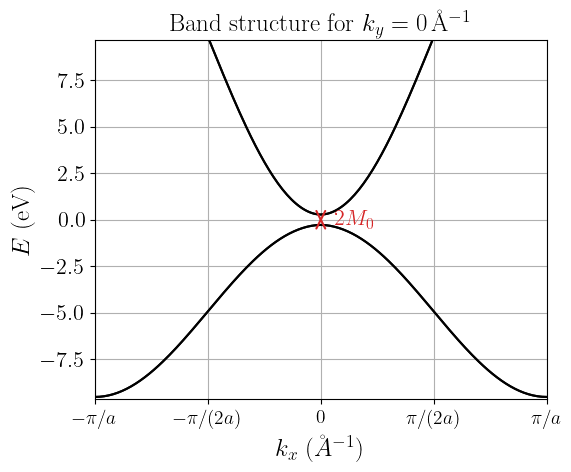

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
Npts = 201
a = H_params['a']
H_params['ky'] = 0.0

# Create kx grid in Å^{-1}
kx_vals = np.linspace(-np.pi / a, np.pi / a, Npts)

# Compute eigenvalues for each kx
E_all = np.empty((Npts, 4))  # BHZ model has 4 bands

for i, kx in enumerate(kx_vals):
    H_params['kx'] = kx
    H = Hamiltonian_BHZ(params=H_params)
    E_all[i] = np.linalg.eigvalsh(H)

# Plot band structure
fig, ax = plt.subplots(figsize=(6, 5))

for band in E_all.T:
    ax.plot(kx_vals, band, color='black')

# Double-headed arrow indicating 2M0
m0 = H_params['M0']
ax.annotate(
    '',
    xy=(0,  -m0), xytext=(0, m0),
    arrowprops=dict(arrowstyle='<->', lw=1.5, color='tab:red'),
)
ax.text(
    0.05, 0.0, r'$2M_0$',
    va='center', ha='left', color='tab:red'
)

# Set xticks and labels in units of π/a
xticks = np.array([-np.pi, -np.pi/2, 0, np.pi/2, np.pi]) / a
xtick_labels = [r"$-\pi/a$", r"$-\pi/(2a)$", r"$0$", r"$\pi/(2a)$", r"$\pi/a$"]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, fontsize=14)

ax.set_xlim(kx_vals[0], kx_vals[-1])
energy_lim = np.max(np.abs(E_all)) / 2
ax.set_ylim(-energy_lim, energy_lim)

ax.grid(True)

# Corrected axis labels without \text{…}
ax.set_xlabel(r'$k_x\ (\AA^{-1})$', fontsize=18)
ax.set_ylabel(r'$E\ (\mathrm{eV})$', fontsize=18)
ax.set_title(rf'Band structure for $k_y = 0\,$\AA$^{{-1}}$', fontsize=18)

plt.tight_layout()
plt.show()

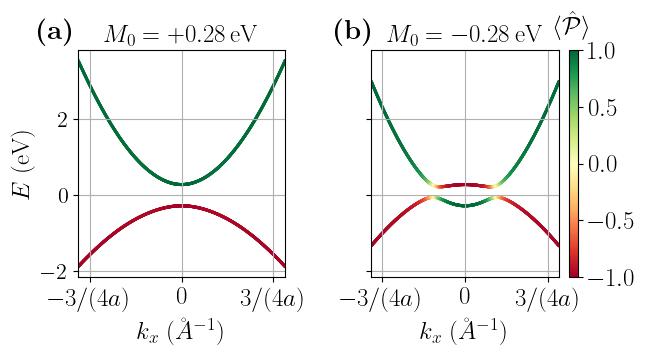

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def parity_operator(n_bands):
    """
    Return a diagonal parity operator with eigenvalues [1, -1, 1, -1, ...]
    for n_bands (must be even).
    """
    return np.diag([1 if i % 2 == 0 else -1 for i in range(n_bands)])

# --- General parameters ---
Npts = 501
H_params['G'] = 0.0
H_params['T'] = 0.0
a = H_params['a']
H_params['ky'] = 0.0

# kx grid in Å^{-1}, roughly covering [-0.75/a, 0.75/a]
kx_vals = np.linspace(-0.75/a - 0.1/a, 0.75/a + 0.1/a, Npts)

# Precompute parity operator (4×4 for BHZ)
P_op = parity_operator(4)

fig, axs = plt.subplots(1, 2, figsize=(9*0.75, 5*0.75), sharey=True)

for idx, M0_sign in enumerate([+1, -1]):
    H_params['M0'] = abs(H_params['M0']) * M0_sign

    E_all = np.empty((Npts, 4))
    parities = np.empty((Npts, 4))

    for i, kx in enumerate(kx_vals):
        H_params['kx'] = kx
        H = Hamiltonian_BHZ(params=H_params)
        # Diagonalize and obtain eigenvectors
        E, V = np.linalg.eigh(H)
        E_all[i] = E

        # Compute parity expectation for each eigenvector
        parities[i] = np.real(np.diag(V.conj().T @ (P_op @ V)))

    # Discrete colormap for parity
    cmap = plt.get_cmap('RdYlGn')
    norm = plt.Normalize(-1, 1)

    ax = axs[idx]
    for band_vals, parity_vals in zip(E_all.T, parities.T):
        ax.scatter(kx_vals, band_vals, c=parity_vals, cmap=cmap, norm=norm, s=5, lw=0)

    ax.set_xlabel(r'$k_x\ (\AA^{-1})$', fontsize=18)
    if idx == 0:
        ax.set_ylabel(r'$E\ (\mathrm{eV})$', fontsize=18)

    # xticks at [-π/a, -π/(2a), -3/(4a), 0, 3/(4a), π/(2a), π/a]
    xticks = np.array([-np.pi, -np.pi/2, -0.75, 0, 0.75, np.pi/2, np.pi]) / a
    xtick_labels = [r"$-\pi/a$", r"$-\pi/(2a)$", r"$-3/(4a)$",
                    r"$0$", r"$3/(4a)$", r"$\pi/(2a)$", r"$\pi/a$"]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, fontsize=18)

    ax.tick_params(axis='y', labelsize=16)
    ax.set_title(rf'$M_0 = {H_params["M0"]:+.2f}\,\mathrm{{eV}}$', fontsize=18)
    ax.grid(True)
    ax.set_xlim(kx_vals[0], kx_vals[-1])

# Add colorbar for parity on the right of the second subplot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(sm, cax=cax)
cbar.ax.set_title(r"$\langle \hat{\mathcal{P}}\rangle$", fontsize=18, pad=12)
cbar.ax.tick_params(labelsize=18)

# Label subplots with (a), (b)
create_letters(axs, coord=(-0.2, 1.05))

plt.tight_layout()
plt.subplots_adjust(top=0.85)
#plt.savefig(' ', bbox_inches='tight')
plt.show()

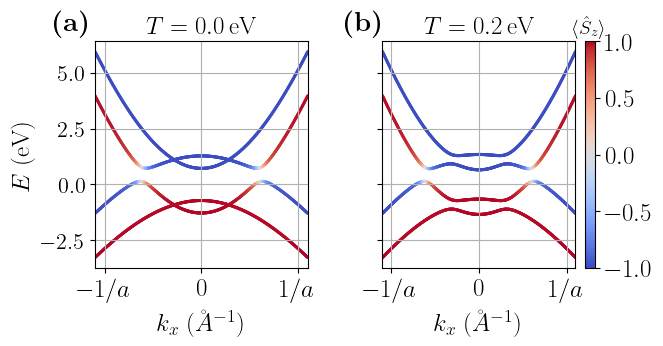

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def parity_operator(n_bands):
    """
    Return a diagonal parity operator with eigenvalues [1, -1, 1, -1].
    n_bands must be 4 for the BHZ model.
    """
    return np.diag([1, -1, 1, -1])

def spin_operator(n_bands):
    """
    Return a diagonal spin operator with eigenvalues [-1, 1, 1, -1].
    n_bands must be 4 for the BHZ model.
    """
    return np.diag([-1, 1, 1, -1])

# --- General parameters ---
Npts = 501
a = H_params['a']
H_params['G'] = 1.0
H_params['ky'] = 0.0

# Precompute operators for a 4-band BHZ model
P_op = parity_operator(4)
S_op = spin_operator(4)

# kx grid in Å^{-1}
kx_vals = np.linspace(-1/a - 0.1/a, 1/a + 0.1/a, Npts)

fig, axs = plt.subplots(1, 2, figsize=(9*0.75, 5*0.75), sharey=True)

for idx, T_val in enumerate([0.0, 0.2]):
    H_params['T'] = T_val
    E_all = np.empty((Npts, 4))
    parities = np.empty((Npts, 4))
    spins = np.empty((Npts, 4))

    for i, kx in enumerate(kx_vals):
        H_params['kx'] = kx
        H = Hamiltonian_BHZ(params=H_params)
        E, V = np.linalg.eigh(H)
        E_all[i] = E

        # Compute expectation of parity and spin for each eigenvector
        parities[i] = np.real(np.diag(V.conj().T @ (P_op @ V)))
        spins[i] = np.real(np.diag(V.conj().T @ (S_op @ V)))

    ax = axs[idx]
    # Choose colormap for spin
    cmap_S = plt.get_cmap('coolwarm')
    norm = plt.Normalize(-1, 1)

    # Plot each band colored by spin expectation
    for band_vals, spin_vals in zip(E_all.T, spins.T):
        ax.scatter(kx_vals, band_vals, c=spin_vals, cmap=cmap_S, norm=norm, s=5, lw=0)

    ax.set_xlabel(r'$k_x\ (\AA^{-1})$', fontsize=18)
    if idx == 0:
        ax.set_ylabel(r'$E\ (\mathrm{eV})$', fontsize=18)

    # xticks at [-π/a, -π/(2a), -1/a, 0, 1/a, π/(2a), π/a]
    xticks = np.array([-np.pi, -np.pi/2, -1, 0, 1, np.pi/2, np.pi]) / a
    xtick_labels = [r"$-\pi/a$", r"$-\pi/(2a)$", r"$-1/a$",
                    r"$0$", r"$1/a$", r"$\pi/(2a)$", r"$\pi/a$"]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, fontsize=18)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_title(rf'$T = {H_params["T"]:.1f}\,\mathrm{{eV}}$', fontsize=18)
    ax.grid(True)
    ax.set_xlim(kx_vals[0], kx_vals[-1])

# Add colorbar for spin on the right of the second subplot
sm_S = plt.cm.ScalarMappable(cmap=cmap_S, norm=norm)
sm_S.set_array([])

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(sm_S, cax=cax)
cbar.ax.set_title(r"$\langle \hat{S}_z \rangle$", fontsize=14, pad=6)
cbar.ax.tick_params(labelsize=18)

# Label subplots with (a) and (b)
create_letters(axs, coord=(-0.2, 1.05))

plt.tight_layout()
plt.subplots_adjust(top=0.85)
#plt.savefig('', bbox_inches='tight')
plt.show()

## Topological invariants

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap
from tqdm import tqdm

# ----------------------------------------------------------------------------------
# 1) Define helper functions
# ----------------------------------------------------------------------------------
def M_k(kx, ky, M0, M2, a):
    """
    Compute the Dirac mass term M(k) = M0 + (2*M2/a^2)[2 - cos(kx a) - cos(ky a)].
    """
    return M0 + (2 * M2 / a**2) * (2 - np.cos(kx * a) - np.cos(ky * a))

def minimum_gap_squared(M0, M2, A, a, KX, KY, sin2_grid):
    """
    For a given (M0, M2), compute the squared half-gap on the full k-grid:
        gap^2(k) = M(k)^2 + (A/a)^2 [sin^2(kx a) + sin^2(ky a)]
    Returns the minimum value of that expression.
    """
    Mk_grid = M_k(KX, KY, M0, M2, a)
    return np.min(Mk_grid**2 + (A / a)**2 * sin2_grid)

# ----------------------------------------------------------------------------------
# 2) Parameter ranges
# ----------------------------------------------------------------------------------
M0_vals = np.linspace(-8.0, 8.0, 501)   # eV
M2_vals = np.linspace(-1.0, 1.0, 501)   # eV·Å²
nbins = len(M0_vals)

# Fixed parameters
A, a = 1.0, 1.0   # eV·Å, Å

# Small k-space mesh for gap computation
Nk = 151
kgrid = np.linspace(-np.pi / a, np.pi / a, Nk)
KX, KY = np.meshgrid(kgrid, kgrid, indexing='ij')
sin2_grid = np.sin(KX * a)**2 + np.sin(KY * a)**2

# TRIM points for the ℤ₂ invariant
TRIM = [
    (0.0,        0.0),
    (np.pi / a,  0.0),
    (0.0,        np.pi / a),
    (np.pi / a,  np.pi / a)
]

# ----------------------------------------------------------------------------------
# 3) Allocate maps: minimum gap and Z2
# ----------------------------------------------------------------------------------
gap_map = np.empty((nbins, nbins))
z2_map  = np.empty((nbins, nbins), dtype=int)  # 0 = trivial, 1 = topological

# ----------------------------------------------------------------------------------
# 4) Fill the maps
# ----------------------------------------------------------------------------------
for i, M0 in enumerate(tqdm(M0_vals, desc="Scanning M0")):
    for j, M2 in enumerate(M2_vals):
        # Compute half-gap squared over the k-grid, then take min and multiply by 2
        min_gap_sq = minimum_gap_squared(M0, M2, A, a, KX, KY, sin2_grid)
        gap_map[j, i] = 2 * np.sqrt(min_gap_sq)

        # Compute ℤ₂ invariant as product of sign[M(k_TRIM)]
        prod_sign = 1
        for kx_trim, ky_trim in TRIM:
            prod_sign *= np.sign(M_k(kx_trim, ky_trim, M0, M2, a))
        z2_map[j, i] = 1 if prod_sign < 0 else 0

# Avoid zeros for log-plotting
gap_map[gap_map < 1e-4] = 1e-4

Scanning M0: 100%|██████████| 501/501 [01:03<00:00,  7.84it/s]


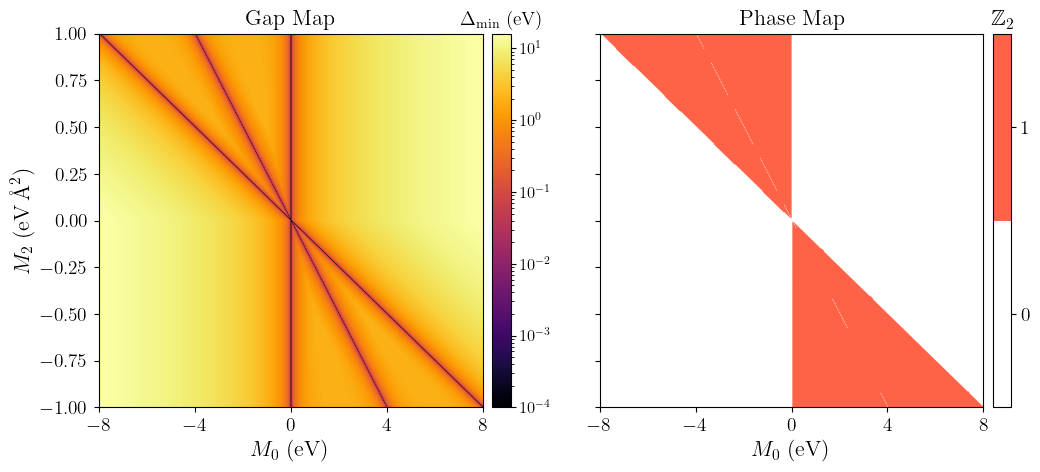

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap

# ----------------------------------------------------------------------------------
# 4) Plot: Gap Map and Z2 Phase Map
# ----------------------------------------------------------------------------------
fig, (ax_gap, ax_z2) = plt.subplots(1, 2, figsize=(11, 5),
                                    sharex=True, sharey=True)

# (a) Minimum gap on a logarithmic scale
eps = 1e-5
gap_nonzero = gap_map[gap_map > 0].min()
im0 = ax_gap.imshow(
    gap_map + eps,
    origin='lower',
    cmap='inferno',
    norm=LogNorm(vmin=gap_nonzero, vmax=gap_map.max()),
    extent=[M0_vals[0], M0_vals[-1], M2_vals[0], M2_vals[-1]],
    aspect='auto'
)
cbar0 = fig.colorbar(im0, ax=ax_gap, pad=0.02)
cbar0.ax.set_title(r"$\Delta_{\min}$ (eV)", fontsize=14)
cbar0.ax.tick_params(labelsize=12)

# (b) Z2 map with a binary colormap
cmap_z2 = ListedColormap(['white', 'tomato'])
im1 = ax_z2.imshow(
    z2_map,
    origin='lower',
    cmap=cmap_z2,
    vmin=0, vmax=1,
    extent=[M0_vals[0], M0_vals[-1], M2_vals[0], M2_vals[-1]],
    aspect='auto'
)
cbar1 = fig.colorbar(im1, ax=ax_z2, ticks=[0.25, 0.75], pad=0.02)
cbar1.ax.set_yticklabels(['0', '1'], fontsize=14)
cbar1.ax.set_title(r"$\mathbb{Z}_2$", fontsize=16)

# Common axes settings
for ax in (ax_gap, ax_z2):
    ax.set_xlabel(r"$M_0$ (eV)", fontsize=16)
    ax.set_xticks([-8, -4, 0, 4, 8])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

ax_gap.set_ylabel(r"$M_2$ (eV\,\AA$^2$)", fontsize=16)
ax_gap.set_title("Gap Map", fontsize=16)
ax_z2.set_title("Phase Map", fontsize=16)

plt.tight_layout()
#plt.savefig("", bbox_inches='tight')
plt.show()

/var/folders/tv/w7tvz05d1j781wvdwyk3sq100000gn/T/ipykernel_7377/2364777341.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


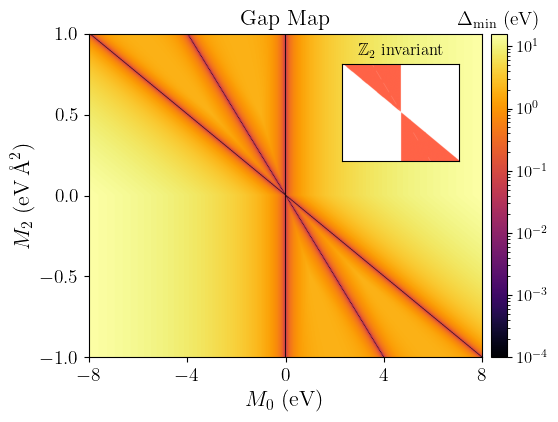

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --------------------------------------
# Plot: Gap map with Z2 inset
# --------------------------------------
fig, ax_gap = plt.subplots(1, 1, figsize=(8 * 0.75, 6 * 0.75))

# Main plot: minimum gap with logarithmic scale
eps = 1e-5
vmin = gap_map[gap_map > 0].min()
im0 = ax_gap.imshow(
    gap_map + eps,
    origin='lower',
    cmap='inferno',
    norm=LogNorm(vmin=vmin, vmax=gap_map.max()),
    extent=[M0_vals[0], M0_vals[-1], M2_vals[0], M2_vals[-1]],
    aspect='auto'
)
cbar0 = fig.colorbar(im0, ax=ax_gap, pad=0.02)
cbar0.ax.set_title(r"$\Delta_{\min}$ (eV)", fontsize=14)
cbar0.ax.tick_params(labelsize=12)

# Configure main axes
ax_gap.set_xlabel(r"$M_0$ (eV)", fontsize=16)
ax_gap.set_ylabel(r"$M_2$ (eV\,\AA$^2$)", fontsize=16)
ax_gap.set_xticks([-8, -4, 0, 4, 8])
ax_gap.set_yticks([-1, -0.5, 0, 0.5, 1])
ax_gap.tick_params(axis='x', labelsize=14)
ax_gap.tick_params(axis='y', labelsize=14)
ax_gap.set_title("Gap Map", fontsize=16)

# --------------------------------------
# Inset: Z2 binary map in the bottom right
# --------------------------------------
ax_inset = inset_axes(
    ax_gap,
    width="30%", height="30%",
    loc='upper right',
    bbox_to_anchor=(0.0, -0.025, 1, 1),
    bbox_transform=ax_gap.transAxes,
    borderpad=1
)

cmap_z2 = ListedColormap(['white', 'tomato'])
im1 = ax_inset.imshow(
    z2_map,
    origin='lower',
    cmap=cmap_z2,
    vmin=0, vmax=1,
    extent=[M0_vals[0], M0_vals[-1], M2_vals[0], M2_vals[-1]],
    aspect='auto'
)
ax_inset.set_title(r"$\mathbb{Z}_2$ invariant", fontsize=12)
ax_inset.set_xticks([])
ax_inset.set_yticks([])

# --------------------------------------
# Final adjustments
# --------------------------------------
plt.tight_layout()
#plt.savefig("", dpi=300, bbox_inches='tight')
plt.show()

In [107]:
"""
Direct-gap and topological phase maps
------------------------------------
Compute the minimum direct gap Δ_min(M₀,G) of the BHZ+G+T lattice model
over the full (k_x,k_y) Brillouin zone.
Results are stored in `gap_map[G_index, M0_index]`.
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap
from tqdm import tqdm

# ------------------------------------------------------------
# 1) Model constants
# ------------------------------------------------------------
a   = 4.0          # Å
A2  = 1.0          # eV·Å
M2  = 8.0          # eV·Å²
T   = 0.25         # eV
# M0 will be scanned, default value unused here

# ------------------------------------------------------------
# 2) Parameter ranges (plot axes)
# ------------------------------------------------------------
M0_values = np.linspace(-6.0,  2.0, 350)   # X-axis → M0 (eV)
G_values  = np.linspace(-3.0,  3.0, 350)   # Y-axis → G  (eV)

# ------------------------------------------------------------
# 3) k-space mesh for gap evaluation
# ------------------------------------------------------------
Nk = 301
k = np.linspace(-np.pi / a, np.pi / a, Nk)
kx_grid, ky_grid = np.meshgrid(k, k, indexing='ij')

cos_kx = np.cos(kx_grid * a)
cos_ky = np.cos(ky_grid * a)
sin2_kx = np.sin(kx_grid * a)**2
sin2_ky = np.sin(ky_grid * a)**2

dxy_term = 2 - cos_kx - cos_ky               # 2 – cos(kx a) – cos(ky a)
kin_xy   = (A2**2 / a**2) * (sin2_kx + sin2_ky)

# ------------------------------------------------------------
# 4) Gap map Δ_min(M0,G)
# ------------------------------------------------------------
gap_map = np.empty((len(G_values), len(M0_values)))

for iG, G_param in enumerate(tqdm(G_values, desc="Scanning G")):
    for jM0, M0_param in enumerate(M0_values):

        M_k   = M0_param + (2 * M2 / a**2) * dxy_term
        inner = np.sqrt(M_k**2 + T**2)

        t_plus  = np.sqrt(kin_xy + (G_param + inner)**2)
        t_minus = np.sqrt(kin_xy + (G_param - inner)**2)

        E_stack  = np.array([-t_plus, -t_minus, t_minus, t_plus])
        E_sorted = np.sort(E_stack, axis=0)
        
        gaps_k = np.abs(E_sorted)
        gap_val = gaps_k.min() 

        gap_map[iG, jM0] = max(gap_val, 1e-5)   # avoid log(0)

Scanning G: 100%|██████████| 350/350 [05:31<00:00,  1.06it/s]


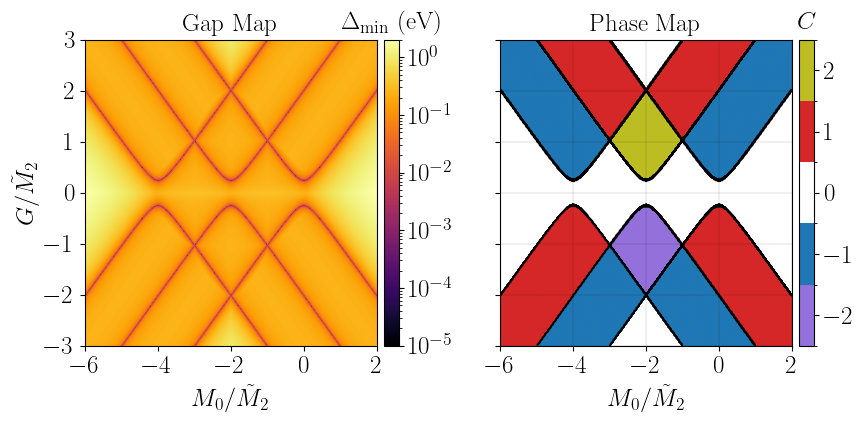

In [ ]:
"""
Gap map (log-scale) and topological phase map (Chern index) side-by-side.
"""

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap, BoundaryNorm
from scipy import ndimage            # needed for connected-component labelling

# ------------------------------------------------------------
# 1) Global Matplotlib settings
# ------------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 18,
    "axes.titlesize": 18,
})

# ------------------------------------------------------------
# 2) Identify gapped regions (gap_map computed earlier)
# ------------------------------------------------------------
thr = 2e-2                      # threshold: gap “closed” if Δ < thr
inside = gap_map >= thr         # True → finite gap

labels, n_reg = ndimage.label(
    inside,
    structure=[[0, 1, 0],
               [1, 1, 1],
               [0, 1, 0]]
)

# ------------------------------------------------------------
# 3) Manual assignment {label → (Chern, colour)}
# ------------------------------------------------------------
phase_dict = {
     1: ( 1, "tab:red"),
     2: (-1, "tab:blue"),
     3: ( 0, "white"),
     4: (-1, "tab:blue"),
     5: ( 1, "tab:red"),
     6: ( 0, "white"),
     7: (-2, "mediumpurple"),
     8: (-1, "tab:blue"),
     9: ( 2, "tab:olive"),
    10: (-1, "tab:blue"),
    11: ( 1, "tab:red"),
    12: ( 1, "tab:red"),
    13: ( 0, "white"),
}

code_map = np.full_like(labels, np.nan, dtype=float)
code2color = {}

for lab, (code, colour) in phase_dict.items():
    if lab > n_reg:
        raise ValueError(f"Label {lab} does not exist (only 1..{n_reg}).")
    code_map[labels == lab] = code
    code2color[code] = colour      # duplicates overwrite, fine

code_list  = np.array(sorted(code2color))            # e.g. [-2,-1,0,1,2]
color_list = [code2color[c] for c in code_list]

cmap_phase = ListedColormap(color_list, N=len(code_list))
cmap_phase.set_bad("black")                          # mask / borders
bounds      = np.arange(code_list.min() - 0.5,
                        code_list.max() + 1.5, 1)
norm_phase  = BoundaryNorm(bounds, cmap_phase.N)
code_masked = np.ma.masked_invalid(code_map)

# ------------------------------------------------------------
# 4) Figure with shared-y subplots
# ------------------------------------------------------------
fig, (ax_gap, ax_phase) = plt.subplots(
    1, 2, sharey=True, figsize=(12 * 0.75, 6 * 0.75)
)

# 4.1 Gap map (log scale)
vmin = gap_map[gap_map > 0].min()
im_gap = ax_gap.imshow(
    gap_map,
    origin="lower",
    extent=[M0_values.min(), M0_values.max(),
            G_values.min(),  G_values.max()],
    aspect="auto",
    cmap="inferno",
    norm=LogNorm(vmin=vmin, vmax=gap_map.max()),
)

ax_gap.set_xlabel(r"$M_0/\tilde{M}_2$")
ax_gap.set_ylabel(r"$G/\tilde{M}_2$")
ax_gap.set_xticks([-6, -4, -2, 0, 2])
ax_gap.set_yticks([-3, -2, -1, 0, 1, 2, 3])
ax_gap.set_title("Gap Map")
ax_gap.tick_params(labelsize=18)

cbar_gap = fig.colorbar(im_gap, ax=ax_gap, pad=0.02)
cbar_gap.ax.set_title(r"$\Delta_{\min}$ (eV)", pad=8, fontsize=18)
cbar_gap.ax.tick_params(labelsize=18)

# 4.2 Phase map (Chern number)
im_phase = ax_phase.imshow(
    code_masked,
    origin="lower",
    cmap=cmap_phase,
    norm=norm_phase,
    extent=[M0_values.min(), M0_values.max(),
            G_values.min(),  G_values.max()],
    aspect="auto",
)

# Contours separate distinct labels
ax_phase.contour(
    labels, levels=np.arange(0.5, n_reg + 1, 1),
    colors="k", linewidths=0.5, origin="lower",
    extent=[M0_values.min(), M0_values.max(),
            G_values.min(),  G_values.max()],
)

ax_phase.set_xlabel(r"$M_0/\tilde{M}_2$")
ax_phase.set_xticks([-6, -4, -2, 0, 2])
ax_phase.set_title("Phase Map")
ax_phase.tick_params(labelsize=18)
ax_phase.grid(color="k", lw=0.3, alpha=0.3)

cbar_phase = fig.colorbar(
    im_phase, ax=ax_phase, pad=0.02,
    boundaries=bounds, ticks=code_list,
)
cbar_phase.ax.set_title(r"$C$", pad=8, fontsize=18)
cbar_phase.ax.tick_params(labelsize=18)

plt.tight_layout()
#plt.savefig(" ", dpi=300, bbox_inches="tight")
plt.show()

## Ribbons 

In [146]:
"""
Tight-binding ribbon for the 1D BHZ chain (kwant)
------------------------------------------------
Returns a finalised kwant system with 4-orbital sites and nearest-
neighbour hopping along ẑ.  The onsite and hopping matrices follow
the notations of the main text.

Parameters expected in *params*:
    a   : lattice constant (Å)
    L   : ribbon length (Å)
    C0, C2,
    M0, M2,
    A, G, T : BHZ + Zeeman + inversion-breaking
"""
import sys
import kwant
import numpy as np

sys.path.append("..")               # repository root for FuncsChern
from FuncsChern import *            # noqa: F403, provides Pauli blocks

# Pauli matrices
s0 = np.eye(2, dtype=complex)
sx = np.array([[0, 1], [1, 0]], dtype=complex)
sy = np.array([[0, -1j], [1j, 0]], dtype=complex)
sz = np.array([[1, 0], [0, -1]], dtype=complex)

# Γ matrices (spin⊗orbital)
G00 = np.kron(s0, s0)
G0z = np.kron(s0, sz)
G0x = np.kron(s0, sx)
Gzy = np.kron(sz, sy)
Gzz = np.kron(sz, sz)
Gyy = np.kron(sy, sy)


def ribbon_bhz(params):
    a, L = params["a"], params["L"]
    lat = kwant.lattice.chain(a, norbs=4)

    # On-site term H₀(kₓ)
    def onsite(site, kx, C0, C2, M0, M2, A, G, T):
        ck2 = 2 - np.cos(kx * a)
        eps0 = C0 + 2 * C2 * ck2 / a**2
        M0k  = M0 + 2 * M2 * ck2 / a**2

        return (
            eps0 * G00 +
            M0k  * G0z +
            (A / a) * np.sin(kx * a) * G0x +
            G * Gzz +
            T * Gyy
        )

    # Nearest-neighbour hopping along ẑ
    def hopping(site1, site2, C2, M2, A):
        return (
            -(C2 * G00 + M2 * G0z) / a**2 +
            1j * A / (2 * a) * Gzy
        )

    syst = kwant.Builder()
    Nz = int(L / a)

    for z in range(Nz):
        syst[lat(z)] = onsite
    syst[kwant.builder.HoppingKind((1,), lat, lat)] = hopping

    return syst.finalized()

In [147]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ------------------------------------------------------------
# 1) Model parameters
# ------------------------------------------------------------
params = dict(
    L  = 200,      # ribbon length (Å)
    a  = 4.0,         # lattice constant (Å)
    C0 = 0.0,
    C2 = 0.0,
    M0 = -0.28,
    M2 = 56.0,
    A  = 4.1,
    G  = 0.0,
    T  = 0.0,
)

# Build the kwant ribbon once
syst = ribbon_bhz(params)          # ribbon_bhz imported from previous cell

# ------------------------------------------------------------
# 2) kx sweep for the quasi-1D band structure
# ------------------------------------------------------------
kx_vals = np.linspace(-0.5, 0.5, 301)      # Å⁻¹
E_all   = []
vec_all = []                               # drop if eigenvectors not needed

for kx in tqdm(kx_vals, desc="Diagonalising"):
    H_k = syst.hamiltonian_submatrix(params={**params, "kx": kx})
    E, V = np.linalg.eigh(H_k)             # E already sorted for Hermitian H
    E_all.append(E)
    vec_all.append(V)                      # comment out if not required

E_all   = np.stack(E_all)                  # shape (Nkx, Nstates)
vec_all = np.stack(vec_all)                # comment out if not required

Diagonalising:   0%|          | 0/301 [00:00<?, ?it/s]

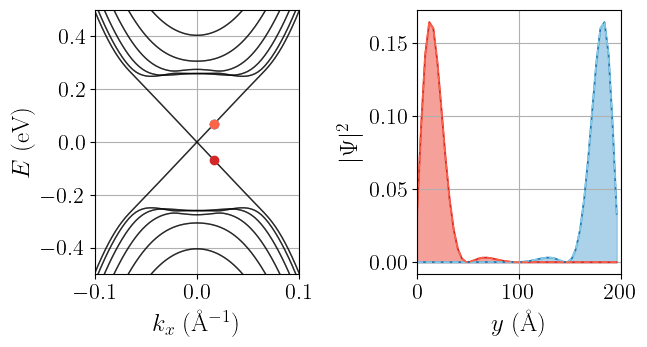

In [151]:
"""
Ribbon spectrum and edge–state localisation
-------------------------------------------
* 1D BHZ ribbon built with `kwant` (see ``ribbon_bhz`` earlier).
* Diagonalise H(kₓ) on a uniform k-grid and visualise:
    (a) band structure,
    (b) probability density |Ψ(y)|² for four representative states.
"""

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import kwant

# --------------------------------------------------------------------
# 1)  Tight-binding ribbon
# --------------------------------------------------------------------

syst   = ribbon_bhz(params)                     # from previous cell
Nsite  = syst.graph.num_nodes                  # 4 × Nz
Nkx    = 301
#kx_vals = np.linspace(-0.5, 0.5, Nkx)          # Å⁻¹
# --------------------------------------------------------------------
# 3)  Density operator (onsite |ψ|²)
# --------------------------------------------------------------------
density_op = kwant.operator.Density(syst, np.kron(np.eye(2), np.eye(2)))

# helper to evaluate |Ψ|² on real-space chain
def real_density(vec):
    """Return onsite probability density for a state vector."""
    return density_op(vec).real                # length = Nsite

# --------------------------------------------------------------------
# 4) Select two k-points and the two states closest to E=0
# --------------------------------------------------------------------
mid = Nkx // 2
k_indices = [mid + 5, mid + 10]               # arbitrary offsets
state_indices = []

for kidx in k_indices:
    # energies closest to 0 at this kx
    state_indices.append(
        np.argsort(np.abs(E_all[kidx]))[:2]    # two states
    )

# Flatten: [(kidx, band), ...]
selection = [(k_indices[i // 2], band)
             for i, two in enumerate(state_indices)
             for band in two]

# --------------------------------------------------------------------
# 5)  Plot
# --------------------------------------------------------------------
fig, (ax_band, ax_den) = plt.subplots(1, 2, figsize=(9 * 0.75, 5 * 0.75))

# (a) band structure
for band in E_all.T:
    ax_band.plot(kx_vals, band, color="black", lw=1, alpha=0.6)

markers = ["o", "o", "o", "o"]
colours = ["tab:red", "tab:blue", "skyblue", "tomato"]

for (kidx, b_idx), mk, col in zip(selection, markers, colours):
    ax_band.plot(kx_vals[kidx], E_all[kidx, b_idx],
                 mk, ms=6, color=col, zorder=3)

ax_band.set_xlim(-0.1, 0.1)
ax_band.set_ylim(-0.5, 0.5)
ax_band.set_xlabel(r"$k_x$ (Å$^{-1}$)")
ax_band.set_ylabel(r"$E$ (eV)")
ax_band.grid(True)

# (b) probability densities
y_sites = np.arange(Nsite) * params["a"]

for (kidx, b_idx), sty, col in zip(selection, ["-", "-", "--", "--"], colours):
    psi   = vec_all[kidx, :, b_idx]
    dens  = real_density(psi)
    ax_den.plot(y_sites, dens, sty, lw=1.2, color=col)
    ax_den.fill_between(y_sites, dens, color=col, alpha=0.3)

ax_den.set_xlim(0, params["L"])
ax_den.set_xlabel(r"$y$ (Å)")
ax_den.set_ylabel(r"$|\Psi|^2$")
ax_den.grid(True)

plt.tight_layout()
#plt.savefig(" ", dpi=300, bbox_inches="tight")
plt.show()

M₀ = +0.0:   0%|          | 0/301 [00:00<?, ?it/s]

M₀ = -2.0:   0%|          | 0/301 [00:00<?, ?it/s]

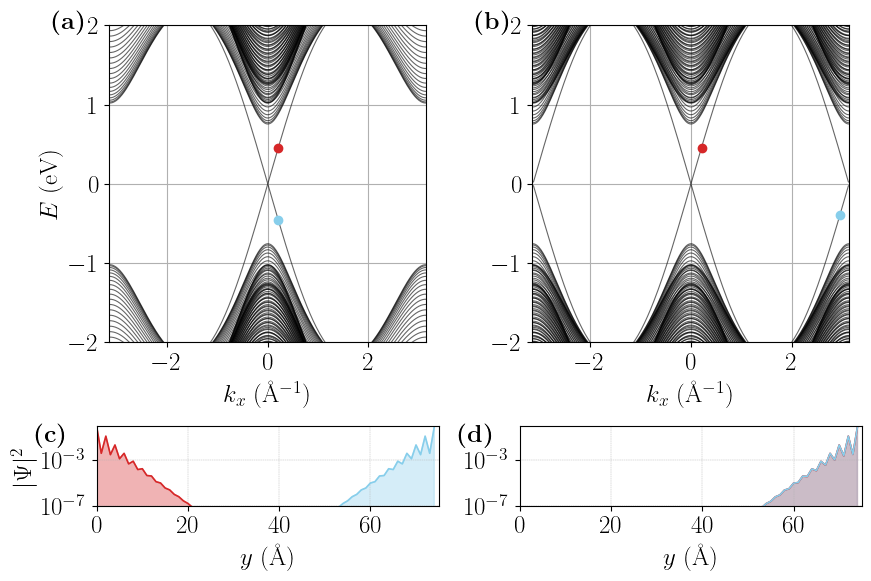

In [152]:
"""
Four-panel comparison:   M₀ = 0  vs  M₀ = –2
-------------------------------------------------------------
Row 0 : band structure E(kₓ)             – square axes
Row 1 : |Ψ(y)|² of two representative states per column
"""

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import kwant

# ------------------------------------------------------------------
# 1)  Lattice and k-mesh
# ------------------------------------------------------------------
a      = 1.0           # Å
Nz     = 75            # sites (y-direction)
L_real = Nz * a        # total length (Å)

Nkx    = 301
kx_vals = np.linspace(-np.pi / a - 0.01 / a,
                      +np.pi / a + 0.01 / a, Nkx)

k_pick = [Nkx // 2 + 10,           # interior point
          Nkx - 10]                # near BZ edge

# ------------------------------------------------------------------
# 2)  Base BHZ parameters (add M₀ later)
# ------------------------------------------------------------------
base_params = dict(
    L=Nz, a=a,
    C0=0.0, C2=0.0,
    M2=0.5, A=2.2,
    G=-1.0, T=0.25
)

M0_list   = [0.0, -2.0]      # columns: 0 → trivial, –2 → Chern ≠ 0
colors    = ["tab:red", "skyblue"]

# ------------------------------------------------------------------
# 3)  Geometry and density operator (fixed once)
# ------------------------------------------------------------------
syst  = ribbon_bhz(base_params)                       # from cleaned helper
dens_op = kwant.operator.Density(syst, np.kron(np.eye(2), np.eye(2)))

# ------------------------------------------------------------------
# 4)  Figure: 2 × 2   (row height ratio 1 : 0.25)
# ------------------------------------------------------------------
fig, axs = plt.subplots(
    2, 2, figsize=(12 * 0.75, 8 * 0.75),
    gridspec_kw=dict(height_ratios=[1, 0.25]),
    sharex=False, sharey=False
)
panel_tags = [r"\textbf{(a)}", r"\textbf{(b)}",
              r"\textbf{(c)}", r"\textbf{(d)}"]

# ------------------------------------------------------------------
# 5)  Loop over M₀ columns
# ------------------------------------------------------------------
for col, M0 in enumerate(M0_list):

    params = base_params | {"M0": M0}          # new dict, no mutation
    E_all, vec_all = [], []

    # --- diagonalise H(kₓ) ---
    for kx in tqdm(kx_vals, desc=f"M₀ = {M0:+}"):
        H_k = syst.hamiltonian_submatrix(params={**params, "kx": kx})
        E, V = np.linalg.eigh(H_k)
        E_all.append(E)
        vec_all.append(V)

    E_all   = np.stack(E_all)                  # shape (Nkx, N)
    vec_all = np.stack(vec_all)                # (Nkx, N, N)
    n_site  = vec_all.shape[2] // 4            # 4 dof per lattice site
    y_pos   = np.arange(n_site) * a

    # ---------------- Panel: bands (row 0) ----------------
    ax_b = axs[0, col]
    for band in E_all.T:
        ax_b.plot(kx_vals, band, lw=0.8, color="black", alpha=0.6)

    #   choose two states
    if col == 0:   # M₀ = 0 → both states at k_pick[0]
        picks = [(k_pick[0], np.argsort(np.abs(E_all[k_pick[0]]))[:2])]
    else:          # M₀ = –2 → one state per k_pick
        picks = [(k_pick[0], [np.argmin(np.abs(E_all[k_pick[0]]))]),
                 (k_pick[1], [np.argmin(np.abs(E_all[k_pick[1]]))])]

    # flatten to list of (k_idx, band_idx)
    sel_states = [(k_idx, int(b))
                  for k_idx, bs in picks for b in np.atleast_1d(bs)]

    for (k_idx, b_idx), c in zip(sel_states, colors*2):
        ax_b.plot(kx_vals[k_idx], E_all[k_idx, b_idx],
                  "o", ms=6, color=c, zorder=3)

    ax_b.set_box_aspect(1)           # square panel
    ax_b.set_xlim(kx_vals[0], kx_vals[-1])
    ax_b.set_ylim(-2, 2)
    ax_b.grid(True)
    ax_b.set_xlabel(r"$k_x$ (Å$^{-1}$)", fontsize=18)
    if col == 0:
        ax_b.set_ylabel(r"$E$ (eV)", fontsize=18)
    ax_b.tick_params(labelsize=18)

    # ---------------- Panel: densities (row 1) ------------
    ax_d = axs[1, col]
    ymax = 0.0
    for (k_idx, b_idx), c in zip(sel_states, colors*2):
        dens = dens_op(vec_all[k_idx, :, b_idx]).real
        ymax = max(ymax, dens.max())
        ax_d.plot(y_pos, dens, lw=1.2, color=c)
        ax_d.fill_between(y_pos, dens, color=c, alpha=0.35)

    ax_d.set_xlim(0, L_real)
    ax_d.set_ylim(1e-7, ymax * 1.1)
    ax_d.set_yscale("log")
    ax_d.grid(True, which="both", ls="--", lw=0.3)
    ax_d.set_xlabel(r"$y$ (Å)", fontsize=18)
    if col == 0:
        ax_d.set_ylabel(r"$|\Psi|^2$", fontsize=18)
    ax_d.tick_params(labelsize=18)

# ------------------------------------------------------------------
# 6)  Panel tags  (a)…(d)
# ------------------------------------------------------------------
for tag, ax in zip(panel_tags, axs.flatten()):
    ax.text(-0.18, 1.05, tag, transform=ax.transAxes,
            ha="left", va="top", fontsize=18)

plt.tight_layout()
#plt.savefig(" ", dpi=300, bbox_inches="tight")
plt.show()

## Magnetic Slab

### Gaps

Computing Δ_min(G,kz):   0%|          | 0/90000 [00:00<?, ?it/s]

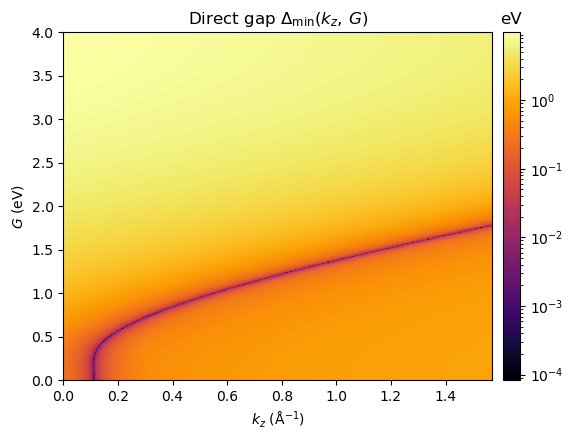

In [ ]:
"""
Direct gap Δ_min(kz, G) for 3-D BHZ — loop version with tqdm.
Keeps the structure of the code you were already running.
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.auto import tqdm

# ------------------------------------------------------------
# 1)  Constants (Bi₂Se₃ tight-binding)
# ------------------------------------------------------------
a   = 4.0          # Å
c   = 2.0          # Å   (half quintuple layer)
A2  = 4.1          # eV·Å
B    = 2.2         # eV·Å
M2  = 56.6         # eV·Å²
M1  = 10.0         # eV·Å²
M0  = -0.28        # eV

# ------------------------------------------------------------
# 2)  Parameter grids (plot axes)
# ------------------------------------------------------------
kz_vals = np.linspace(0.0, np.pi / c, 300)   # X axis
G_vals  = np.linspace(0.0, 4.0, 300)         # Y axis

# ------------------------------------------------------------
# 3)  In-plane (kx,ky) mesh for evaluating the gap
# ------------------------------------------------------------
Nk = 501
kx = np.linspace(-np.pi / a, np.pi / a, Nk)
ky = np.linspace(-np.pi / a, np.pi / a, Nk)
kxg, kyg = np.meshgrid(kx, ky, indexing="ij")

sin2_xy = np.sin(kxg * a) ** 2 + np.sin(kyg * a) ** 2
cos_kx  = np.cos(kxg * a)
cos_ky  = np.cos(kyg * a)
ck2_xy  = 2.0 - cos_kx - cos_ky
kin_xy  = (A2 / a) ** 2 * sin2_xy

# ------------------------------------------------------------
# 4)  Gap map: loop over (G, kz)
# ------------------------------------------------------------
gap_map = np.empty((len(G_vals), len(kz_vals)))

total_iter = len(G_vals) * len(kz_vals)
with tqdm(total=total_iter, desc="Computing Δ_min(G,kz)") as bar:
    for iG, G in enumerate(G_vals):
        for ikz, kz in enumerate(kz_vals):

            inner = np.sqrt(
                (M0 + 2 * M2 / a**2 * ck2_xy + 2 * M1 / c**2 * (1 - np.cos(kz * c))) ** 2
                + (B / c) ** 2 * np.sin(kz * c) ** 2
            )

            t_plus  = np.sqrt(kin_xy + (G + inner) ** 2)
            t_minus = np.sqrt(kin_xy + (G - inner) ** 2)

            # four bands → stack then sort
            bands = np.array([-t_plus, -t_minus, t_minus, t_plus])
            gaps  = np.abs(bands).min(axis=0)     # direct gap at each (kx,ky)
            gap_val = gaps.min()                  # global direct gap

            gap_map[iG, ikz] = max(gap_val, 1e-8)   # prevent log(0)

            bar.update(1)

# optional: hard upper cap (keeps colourbar reasonable)
gap_map = np.clip(gap_map, None, 1e2)

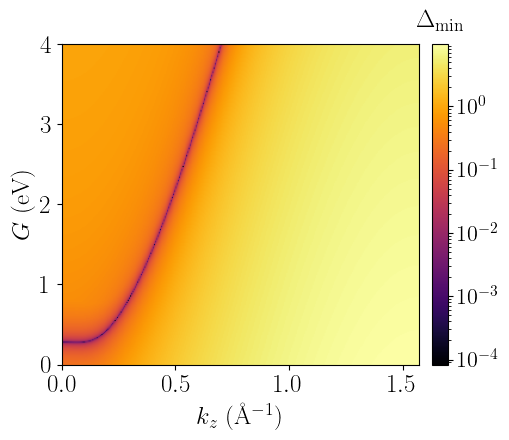

In [7]:
# ------------------------------------------------------------
# 0)  Make sure the gap is strictly positive for LogNorm
# ------------------------------------------------------------
gap_map = np.clip(gap_map, 1e-8, None)   # no-op unless there are zeros

# ------------------------------------------------------------
# 1) CONFIGURACIÓN GLOBAL (fonts & LaTeX)
# ------------------------------------------------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams.update({
    "text.usetex"  : True,
    "font.family"  : "serif",
    "font.serif"   : ["Computer Modern Roman"],
    "axes.labelsize": 15,
    "axes.titlesize": 16,
})

# ------------------------------------------------------------
# 2) SINGLE FIGURE:  Δ_min(kz,G)
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7 * 0.75, 6 * 0.75))

im = ax.imshow(
    gap_map,
    origin="lower",
    extent=[kz_vals.min(), kz_vals.max(),
            G_vals.min(),  G_vals.max()],
    aspect="auto",
    cmap="inferno",
    norm=LogNorm(
        vmin=gap_map.min(),          # already >0 thanks to clip
        vmax=gap_map.max()
    ),
)

ax.set_xlabel(r"$k_z$ (\AA$^{-1}$)", fontsize=18)
ax.set_ylabel(r"$G$ (eV)",           fontsize=18)
ax.tick_params(axis="both", which="both", labelsize=18)

cbar = fig.colorbar(im, ax=ax, pad=0.03)
cbar.ax.set_title(r"$\Delta_{\min}$", pad=12, fontsize=18)
cbar.ax.tick_params(labelsize=16)

# ------------------------------------------------------------
# 3) SAVE / SHOW
# ------------------------------------------------------------
plt.tight_layout()
#plt.savefig(" ", dpi=300)
plt.show()

### Continumm Model

In [ ]:
import sys
import kwant

sys.path.append('..')

from FuncsChern import *
import numpy as np


def Slab_BHZ_z(params):
    a = params["a"]
    c = params["c"]
    L = params["L"]
    lat = kwant.lattice.chain(c,norbs=4)

    def OS(site, kx, ky, a,c, C0, C1, C2, M0, M1, M2, A, G, B):
            ck2_xy = 2.0 - np.cos(kx * a) - np.cos(ky * a)
            epsilon_0 = C0 + (2 * C2 / (a ** 2)) * ck2_xy + (2 * C1 / (c ** 2))
            M_0 = M0 + (2 * M2 / (a ** 2)) * ck2_xy + (2 * M1 / (c ** 2))
            
            OS_matrix = (
                epsilon_0 * np.kron(s0,s0) +
                M_0 * np.kron(s0,sz) +
                (A / a) * (np.sin(kx * a) * np.kron(s0,sx) + np.sin(ky * a) * np.kron(sz,sy)) +
                G * np.kron(sz,sz) 
            )
            return OS_matrix

    def HOP(site1, site2, a, C1, M1, B):
            HOP_matrix = (
                (1 / c ** 2) * (C1 * np.kron(s0,s0) - M1 * np.kron(s0,sz)) +
                -(1j * B) / (2 * c) * np.kron(sy,sy)
            )
            
            return HOP_matrix

    syst = kwant.Builder()
    
    for z in range(int(L/c)):
        syst[lat(z)] = OS
    syst[kwant.builder.HoppingKind((1,), lat, lat)] = HOP


    return syst.finalized()

H_params = {
        "L":30 , 
        "C0":0.,
        "C2": 0,
        "C1": 0,
        "M0":-0.28,
        "G":1,
        "M1": 10,
        "M2": 56.6,
        "A" : 4.1,
        "B" : 2.2,  
        "a" : 4, 
        "c":  2, 
        "ky":0,
            }


syst = Slab_BHZ_z(H_params)

In [ ]:
def Calculate_Everything_KWANT(syst, k_values, H_params, all_bands=True, bands=0):

    H_params["kx"] = 0
    H_params["ky"] = 0
    H_k = syst.hamiltonian_submatrix(params=H_params)
    
    
    Nk = len(k_values)
    dim=H_k.shape[0]

    if not all_bands:
        b = bands
    else:
        b = dim

    eigenenergies = np.zeros((Nk, Nk, b))
    eigenvectors = np.zeros((Nk, Nk, dim, b), dtype=complex)

    previous_evecs_k = None


    for iy, ky in enumerate(tqdm(k_values)):
        for ix, kx in enumerate(k_values):
            H_params["kx"] = kx
            H_params["ky"] = ky
            H_k = syst.hamiltonian_submatrix(params=H_params)
            if previous_evecs_k is not None:
                eigvals, eigvecs,_,_ = compute_eigensystem(H_k, previous_evecs_k)
            else:
                eigvals, eigvecs = compute_eigensystem(H_k)
            eigenvectors[ix, iy, :, :] = eigvecs[:,:b]
            eigenenergies[ix, iy, :] = eigvals[:b]
            previous_evecs_k = eigvecs


    return eigenenergies, eigenvectors


def calcular_chern_banda_KWANT(syst, H_params ,eigenvectors, b, kx_vals, ky_vals):

    Nkx, Nky, dim = eigenvectors.shape
    epsilon = 1e-10  #
    delta_k = 1e-6   


    def compute_U(v1, kx1, ky1, v2, kx2, ky2, b, H_params, shift_kx=False, shift_ky=False):
        U = np.vdot(v1, v2)
        if np.abs(U) < epsilon:
            
            if shift_kx:
                kx2_shifted = kx2 + delta_k
                ky2_shifted = ky2
            elif shift_ky:
                kx2_shifted = kx2
                ky2_shifted = ky2 + delta_k
            else:
                
                kx2_shifted = kx2 + delta_k
                ky2_shifted = ky2

            

            H_params["kx"] = kx2_shifted
            H_params["ky"] = ky2_shifted
            H_k_shifted = syst.hamiltonian_submatrix(params=H_params)

            eigvals_shifted, eigvecs_shifted = LA.eigh(H_k_shifted)
            v2_shifted = eigvecs_shifted[:, b]

            U = np.vdot(v1, v2_shifted)

       
        if np.abs(U) < epsilon:
            U_normalized = 1.0  
        else:
            U_normalized = U / np.abs(U)

        return U_normalized

    
    ChernNumber = 0.0

    
    for iy in range(Nky):
        for ix in range(Nkx):
            
            ix_plus = (ix + 1) % Nkx
            iy_plus = (iy + 1) % Nky

            
            v_ij = eigenvectors[ix, iy, :]
            v_ipj = eigenvectors[ix_plus, iy, :]
            v_ipjp = eigenvectors[ix_plus, iy_plus, :]
            v_ijp = eigenvectors[ix, iy_plus, :]

            kx_ij = kx_vals[ix]
            ky_ij = ky_vals[iy]
            kx_ipj = kx_vals[ix_plus]
            ky_ipj = ky_vals[iy]
            kx_ipjp = kx_vals[ix_plus]
            ky_ipjp = ky_vals[iy_plus]
            kx_ijp = kx_vals[ix]
            ky_ijp = ky_vals[iy_plus]

            
            U1 = compute_U(v_ij, kx_ij, ky_ij, v_ipj, kx_ipj, ky_ipj,b,H_params, shift_kx=True)
            U2 = compute_U(v_ipj, kx_ipj, ky_ipj, v_ipjp, kx_ipjp, ky_ipjp, b,H_params,shift_ky=True)
            U3 = compute_U(v_ipjp, kx_ipjp, ky_ipjp, v_ijp, kx_ijp, ky_ijp, b,H_params,shift_kx=True)
            U4 = compute_U(v_ijp, kx_ijp, ky_ijp, v_ij, kx_ij, ky_ij, b, H_params,shift_ky=True)

           
            F_ij = np.angle(U1 * U2 * U3 * U4)
            ChernNumber += F_ij

  
    ChernNumber = np.round(ChernNumber / (2 * np.pi))

    return ChernNumber

In [ ]:
N_k=150

a = H_params["a"]
c = H_params["c"]
L = int(H_params["L"]/c)
print(L)

kx_values=np.linspace(-np.pi/(a),np.pi/(a),N_k)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection

k_index = N_k//2

efs,wfs=Calculate_Everything_KWANT(syst, kx_values, H_params, all_bands=True, bands=0)

colors_chern = {+1: 'red', -1: 'blue', 0: 'black', +2: 'orange', -2: 'purple'}


dim=L*4
print(dim)
chern_numbers = []

for b in tqdm(range(dim), desc="Computing Cherns", unit="band"):
    ChernNumber = calcular_chern_banda_KWANT(
        syst, H_params , wfs[:, :, :, b], b, kx_values, kx_values
    )
    chern_numbers.append(ChernNumber)

15


  0%|          | 0/150 [00:00<?, ?it/s]

60


Calculando números de Chern:   0%|          | 0/60 [00:00<?, ?banda/s]

In [23]:
VMIN,VMAX=-5,5

3 QLs consideradas
Cn total: -3.0


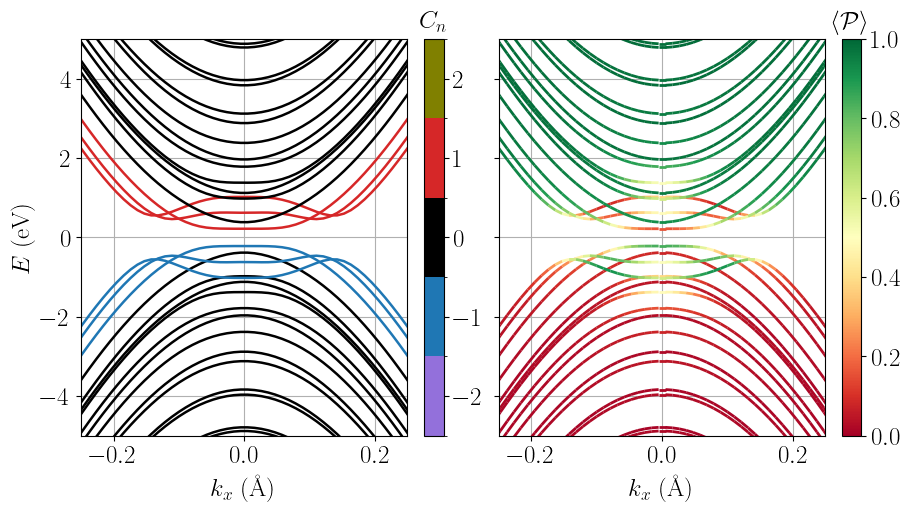

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.collections import LineCollection

# ---------------------------------------------------------------------------
# Matplotlib defaults
# ---------------------------------------------------------------------------
plt.rcParams.update({
    "font.size"       : 18,
    "axes.labelsize"  : 18,
    "axes.titlesize"  : 18,
    "xtick.labelsize" : 18,
    "ytick.labelsize" : 18,
    "legend.fontsize" : 18,
    "figure.titlesize": 18,
})

# ---------------------------------------------------------------------------
# Global constants
# ---------------------------------------------------------------------------
BLOCK_SIZE   = 4                      # orbitals per slab layer
INDEX_PATTERN = {"P": [0, 2]}         # orbital indices in each block

chern_colors = {
    -2: "mediumpurple",
    -1: "tab:blue",
     0: "black",
     1: "tab:red",
     2: "olive",
}

COLORMAPS = {"P": plt.get_cmap("RdYlGn")}
NORM_PROB = mcolors.Normalize(vmin=0, vmax=1)

# ---------------------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------------------
def build_indices(pattern, n_blocks, block_size=BLOCK_SIZE):
    """Return flat indices for every block."""
    base = np.asarray(pattern)
    offs = np.arange(n_blocks) * block_size
    return (base[:, None] + offs).ravel()

def probability_density(abs_sq, indices):
    """Sum |ψ|² over the selected orbitals."""
    return abs_sq[:, :, indices, :].sum(axis=2)

def plot_slab_probability(ax, z, prob_z, chern, colors, *,
                          ylabel="Probability", title="P(z) per band"):
    for b in range(prob_z.shape[1]):
        ax.plot(z, prob_z[:, b], marker="o",
                lw=1.8, color=colors.get(chern[b], "green"))
    ax.set(xlabel="slab $z$", ylabel=ylabel, title=title,
           xlim=(z.min(), z.max()))
    ax.grid(True)

def add_simple_colorbar(fig, ax, cmap, label="Probability"):
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=NORM_PROB)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical")
    cbar.ax.set_title(r"$\langle\mathcal{P}\rangle$", pad=8, fontsize=18)

def add_chern_colorbar(fig, ax, colors):
    labels = sorted(colors)
    cmap   = mcolors.ListedColormap([colors[c] for c in labels])
    bounds = [c - .5 for c in labels] + [labels[-1] + .5]
    norm   = mcolors.BoundaryNorm(bounds, cmap.N)
    sm     = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="vertical",
                        ticks=labels, spacing="uniform")
    cbar.ax.set_title(r"$C_n$", pad=8, fontsize=18)

def plot_energy_bands(ax, kx, E, *,
                      prob=None, cmap=None, norm=None,
                      chern=None, chern_colors=None,
                      title="", xlabel="", ylabel=r"$E$ (eV)"):
    """Draw energy bands with optional colouring."""
    if prob is not None:
        # continuous colouring by probability
        for b in range(E.shape[1]):
            y = E[:, b]
            p = prob[:, b]
            pts = np.array([kx, y]).T.reshape(-1, 1, 2)
            seg = np.concatenate([pts[:-1], pts[1:]], axis=1)
            lc  = LineCollection(seg, cmap=cmap, norm=norm, linewidth=2)
            lc.set_array(0.5 * (p[:-1] + p[1:]))
            ax.add_collection(lc)
    elif chern is not None and chern_colors is not None:
        # discrete colouring by Chern number
        for b in range(E.shape[1]):
            ax.plot(kx, E[:, b], lw=1.8,
                    color=chern_colors.get(chern[b], "green"))
    else:
        ax.plot(kx, E, lw=1.8)

    ax.set(xlim=(-0.25, 0.25), ylim=(VMIN, VMAX),
           xlabel=xlabel, ylabel=ylabel, title=title)
    ax.grid(True)

# ---------------------------------------------------------------------------
# Main pipeline
# ---------------------------------------------------------------------------
def main(kx_vals, efs, wfs, k_idx,
         chern_nums, chern_colors, L,
         *, output="SlabConObservables.pdf"):

    # Data slices ------------------------------------------------------------
    E_band     = efs[:, k_idx, :]        # (Nk, Nb)
    abs_sq     = np.abs(wfs)**2

    probs = {
        key: probability_density(abs_sq,
                                 build_indices(patt, L))[:, k_idx, :]
        for key, patt in INDEX_PATTERN.items()
    }

    # Figure -----------------------------------------------------------------
    fig, axes = plt.subplots(1, 2, figsize=(9, 5),
                             constrained_layout=True, sharey=True)

    # 1) bands coloured by Chern number
    plot_energy_bands(axes[0], kx_vals, E_band,
                      chern=chern_nums,
                      chern_colors=chern_colors,
                      xlabel=r"$k_x$ (\AA)")

    add_chern_colorbar(fig, axes[0], chern_colors)

    # 2) bands coloured by P-probability
    plot_energy_bands(axes[1], kx_vals, E_band,
                      prob=probs["P"],
                      cmap=COLORMAPS["P"],
                      norm=NORM_PROB,
                      xlabel=r"$k_x$ (\AA)",
                      ylabel="")

    add_simple_colorbar(fig, axes[1], COLORMAPS["P"])

    if output:
        fig.savefig("Figs/Bandas30.svg", dpi=300)
    plt.show()

# ---------------------------------------------------------------------------
# Example call (adjust variables before running as __main__)
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    print(f"{int(L*c/10)} QLs considered")
    print(f"Total Chern: {np.sum(chern_numbers[:len(chern_numbers)//2])}")
    main(kx_values, efs, wfs, k_index,
         chern_numbers, chern_colors, L)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

params = {
    "a": 4.0,
    "c":2,
    "A": 4.1,
    "M2": 56.59,
    "M1": 10.0,
    "B": 2.2,
    "M0": -0.28,
}

G_vals = np.linspace(0.0, 4, 500)
L_vals = np.linspace(1, 10*4+10/4, 500)

Nkz = 5001
kx = np.array([0, np.pi / params["a"]])
ky = np.array([0, np.pi / params["a"]])
kx_m, ky_m = np.meshgrid(kx, ky, indexing="ij")
kz_vals = np.linspace(0.0, np.pi / params["c"], Nkz)

sin_kx_a = np.sin(kx_m * params["a"])**2
sin_ky_a = np.sin(ky_m * params["a"])**2
cos_kx_a = np.cos(kx_m * params["a"])
cos_ky_a = np.cos(ky_m * params["a"])
prefactor_trig = (params["A"]**2) / (params["a"]**2) * (sin_kx_a + sin_ky_a)

chern_map = np.zeros((len(L_vals), len(G_vals)), dtype=int)


def Chern_number_counter(crossings: int, params: dict, L: float, kz_best: float | None) -> int:

    L=L/params['c']

    kz_term = int(min(kz_best * params["c"] * (L + 1) / np.pi,L)) if kz_best is not None else None

    if crossings == 0:
        return kz_term if kz_term is not None else int((0))

    if crossings == 1:
        return kz_term if kz_term is not None else int((L))

    if crossings == 2:

        return (L+1 - 2 * kz_term) if kz_term is not None else -int(L+1)

    if crossings == 3:

        return (L+1 - kz_term) if kz_term is not None else 0


    return (L - crossings * kz_term) if kz_term is not None else 0


threshold = 1e-2
crossings = 0          
prev_crossing = False  

for g_idx, G in tqdm(enumerate(G_vals), total=len(G_vals)):
    best_min_abs = np.inf
    kz_best = None   


    for kz in kz_vals:
        sin_kz_c = np.sin(kz * params["c"])
        cos_kz_c = np.cos(kz * params["c"])

        Mk = (params["M0"]
              + 2 * params["M2"] / params["a"] ** 2 * (2 - cos_kx_a - cos_ky_a)
              + 2 * params["M1"] / params["c"] ** 2 * (1 - cos_kz_c))

        sqrt_term = np.sqrt(Mk ** 2 + (params["B"] / params["c"])**2 * sin_kz_c**2)
        F_plus  = prefactor_trig + (G + sqrt_term) ** 2
        F_minus = prefactor_trig + (G - sqrt_term) ** 2

        min_abs_local = np.minimum(np.abs(F_plus), np.abs(F_minus)).min()

        if min_abs_local < best_min_abs and min_abs_local < threshold:
            best_min_abs = min_abs_local
            kz_best = kz


    current_crossing = kz_best is not None
    if current_crossing and not prev_crossing:
        crossings += 1
    prev_crossing = current_crossing


    for l_idx, L in enumerate(L_vals):
        chern_map[l_idx, g_idx] = Chern_number_counter(crossings, params, L, kz_best)


100%|██████████| 500/500 [00:28<00:00, 17.81it/s]


/var/folders/tv/w7tvz05d1j781wvdwyk3sq100000gn/T/ipykernel_51386/3699056886.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_discrete = plt.cm.get_cmap('tab20b', n_val)


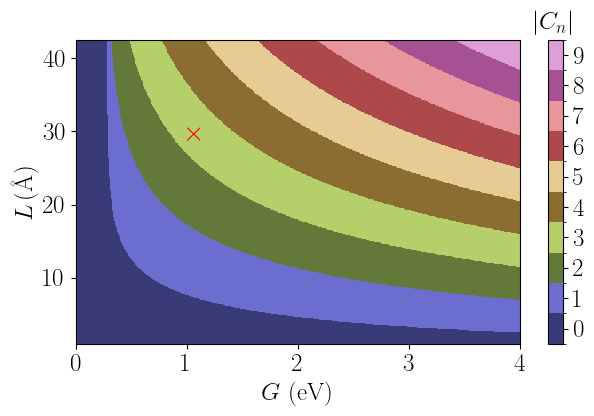

In [31]:

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm


vals = np.sort(np.unique(chern_map))          
n_val = len(vals)                             

cmap_discrete = plt.cm.get_cmap('tab20b', n_val) 

bounds = np.concatenate(([vals[0]-0.5], vals + 0.5))  
norm   = BoundaryNorm(bounds, cmap_discrete.N, clip=True)


plt.rcParams.update({
    "font.size": 18,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

fig, ax = plt.subplots(figsize=(9*0.75, 6*0.75))

im = ax.imshow(
    chern_map,
    origin="lower",
    aspect="auto",
    extent=[G_vals[0], G_vals[-1], L_vals[0], L_vals[-1]],
    interpolation="none",
    cmap=cmap_discrete,
    norm=norm
)

cbar = fig.colorbar(
    im, ax=ax,
    boundaries=bounds,          
    ticks=vals,                 
    spacing='proportional'     
)
cbar.ax.set_title(r"$\left|C_n\right|$", pad=8, fontsize=18)

ax.set_xlabel(r"$G$ (eV)")
ax.set_ylabel(r"$L \, (\mathrm{\AA})$")

plt.tight_layout()
plt.text(
    1, 30.0, r'$\times$',          
    va='center', ha='left', c='r', fontsize=20, fontweight='bold'
)
#plt.savefig('')
plt.show()

### Double Finite Model

In [32]:
import sys

sys.path.append('..')

from FuncsChern import *
import numpy as np
import kwant

# Pauli matrices
sx = np.array([[0, 1],[1, 0]], dtype=complex)
sy = np.array([[0, -1j],[1j, 0]], dtype=complex)
sz = np.array([[1, 0],[0, -1]], dtype=complex)
s0 = np.eye(2, dtype=complex)

def sorted_eigs(ev):
    """ Function to sort the eigenvecs according to the eigenvalue order """ 
    evals, evecs = ev
    order = np.argsort(evals)
    return np.array(evals[order]), np.array(evecs[:, order])

from tqdm import tqdm  # Importar tqdm para la barra de progreso
import scipy.sparse.linalg as sla


def Slab_BHZ_yz(params):
    a   = params["a"]
    c   = params["c"]
    L_y = params["L_y"]  
    L_z = params["L_z"]  


    lat = kwant.lattice.general([(a, 0), (0, c)], basis=[(0, 0)], norbs=4)

    def OS(site, kx, a,c, C0, C1, C2, M0, M1, M2, A, G, B):
            ck2_xy = 2.0 - np.cos(kx * a)
            epsilon_0 = C0 + (2 * C2 / (a ** 2)) * ck2_xy + (2 * C1 / (c ** 2))
            M_0 = M0 + (2 * M2 / (a ** 2)) * ck2_xy + (2 * M1 / (c ** 2))
            
            OS_matrix = (
                epsilon_0 * np.kron(s0,s0) +
                M_0 * np.kron(s0,sz) +
                (A / a) * (np.sin(kx * a) * np.kron(s0,sx)) +
                G * np.kron(sz,sz) 
            )
            return OS_matrix
            

    # Hopping en dirección z
    def HOP_z(site1, site2, c, C1, M1, B):
            HOP_matrix = (
                (1 / c ** 2) * (C1 * np.kron(s0,s0) + M1 * np.kron(s0,sz)) +
                (1j * B) / (2 * c) * np.kron(sy,sy)
            )
            return HOP_matrix

    # Hopping en dirección y
    def HOP_y(site1, site2, a, C2, M2, A):
            HOP_matrix = (
                (1 / a ** 2) * (C2 * np.kron(s0,s0) + M2 * np.kron(s0,sz)) +
                (1j * A) / (2 * a) * np.kron(sz,sy)
            )
            return HOP_matrix

    syst = kwant.Builder()

    
    def shape(pos):
        y, z = pos 
        return (0 <= y < L_y) and (0 <= z < L_z)

    
    syst[lat.shape(shape, (0, 0))] = OS

    # Hoppings en la dirección y
    syst[kwant.builder.HoppingKind((1, 0), lat.sublattices[0], lat.sublattices[0])] =  HOP_y
    #syst[kwant.builder.HoppingKind((-1, 0), lat.sublattices[0], lat.sublattices[0])] = (
    #    lambda s1, s2, a, C2, M2, A: np.conjugate(hopping_y(s2, s1, a, C2, M2, A).T)
    #)

    # Hoppings en la dirección z
    syst[kwant.builder.HoppingKind((0, 1), lat.sublattices[0], lat.sublattices[0])] =  HOP_z
    #syst[kwant.builder.HoppingKind((0, -1), lat.sublattices[0], lat.sublattices[0])] = (
    #    lambda s1, s2, c, C1, M1, B: np.conjugate(hopping_z(s2, s1, c, C1, M1, B).T)
    #)

    return syst.finalized()

H_params = {
        "L_y":200,
        "L_z":30 , ## 10 * QLs * SLABS
        "C0":0.,
        "C2": 0,
        "C1": 0,
        "M0":-0.28,
        "G":1,
        "M1": 10,
        "M2": 56.6,
        "A" : 4.1,
        "B" : 2.2,  
        "a" : 4, ## 4  A
        "c":  2, ## 10A / 3 Sitios por QL
        "ky":0,
            }

#a   = 4
#c   =10/3
#A2  = 4.1/(7.07**2)
#M2  = 8
#M1  = 10/7.07
#B = 2.2/(7.07**2)
#M0   = (-0.28)/7.07
#H_params["kx"] = 0
#H_params["ky"] = 0


syst = Slab_BHZ_yz(H_params)

In [33]:
def sorted_eigs(ev):
    """ Function to sort the eigenvecs according to the eigenvalue order """ 
    evals, evecs = ev
    order = np.argsort(evals)
    return np.array(evals[order]), np.array(evecs[:, order])

from tqdm import tqdm  # Importar tqdm para la barra de progreso
import scipy.sparse.linalg as sla
import scipy.sparse as ss




a= H_params["a"]
c= H_params["c"]

Ly = H_params["L_y"]
Lz = H_params["L_z"]

Ly = int(Ly/a)
Lz = int(Lz/c)


print([Ly,Lz])

N_k      = 51
bands   = 20
kx_values = np.linspace(-0.1, 0.1, N_k)

energy_kx = []
eigenvectors_kx = []
previous_evecs = None

for ki in tqdm(kx_values, desc="Calculando Autovalores/Autovectores", unit="k-point"):
    H_params["kx"] = ki
    H_k = syst.hamiltonian_submatrix(params=H_params, sparse=True)


    ens, wfs = sla.eigsh(H_k.tocsc(), k=bands, sigma=0, return_eigenvectors=True)
    ens, wfs = sorted_eigs([ens, wfs])
    
    energy_kx.append(ens)
    eigenvectors_kx.append(wfs)



energy_kx = np.array(energy_kx)
eigenvectors_kx = np.array(eigenvectors_kx)
eigenvectors_kx = eigenvectors_kx.reshape([N_k, 4*Ly*Lz, bands])

[50, 15]


Calculando Autovalores/Autovectores: 100%|██████████| 51/51 [00:20<00:00,  2.53k-point/s]


/var/folders/tv/w7tvz05d1j781wvdwyk3sq100000gn/T/ipykernel_51386/1677476139.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


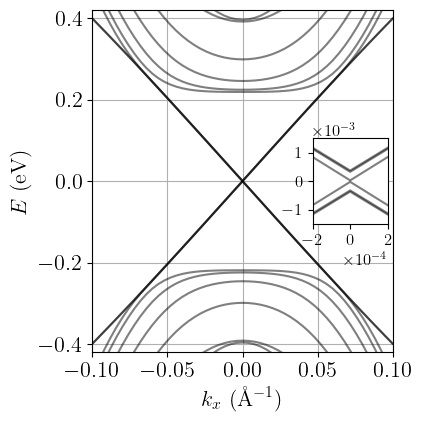

In [34]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import matplotlib.patches as patches   # (opcional) para dibujar un recuadro

plt.rcParams.update({             # todos los textos a tamaño 10
    "font.size": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

# -------------------------------------------------------------------
# 1) Figura y bandas (tu parte, sin cambios sustanciales)
# -------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(6*0.75, 6*0.75))

Emin, Emax = -0.42, 0.42
for j in range(energy_kx.shape[1]):
    ax.plot(kx_values, energy_kx[:, j], alpha=0.5, c='k')

kx_selected_index = N_k // 2 + 1

ax.set_xlim(kx_values[0], kx_values[-1])
ax.set_ylim(Emin, Emax)
ax.set_xlabel(r'$k_x$ (\AA$^{-1}$)')
ax.set_ylabel(r'$E$ (eV)')
plt.grid()

# -------------------------------------------------------------------
# 2) Inset (eje hijo) con zoom
# -------------------------------------------------------------------
axins = inset_axes(
    ax, width="25%", height="25%",   # tamaño relativo
    loc='center right',              # pegado al borde derecho del ax principal
    borderpad=0.2                    # separación en puntos
)

# Re-pintamos las mismas bandas dentro del inset
for j in range(energy_kx.shape[1]):
    axins.plot(kx_values, energy_kx[:, j], alpha=0.5, c='k')

# Límites del zoom
axins.set_xlim(-0.0002, 0.0002)
axins.set_ylim(-0.0015, 0.0015)

from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
axins.xaxis.set_major_formatter(formatter)
axins.yaxis.set_major_formatter(formatter)
axins.ticklabel_format(style='sci', axis='both', scilimits=(-3, 3))
axins.xaxis.offsetText.set_fontsize(12)
axins.yaxis.offsetText.set_fontsize(12)

axins.tick_params(labelsize=12)

# Opcional: menos ticks o más pequeños
axins.tick_params(labelsize=12)

# -------------------------------------------------------------------
# 3) Líneas que conectan inset ↔ zona ampliada
# -------------------------------------------------------------------
# 3.1  (opcional) sombrear/encuadrar la región en el gráfico principal
'''rect = patches.Rectangle(
    (-0.02, -0.1),                   # esquina inferior-izquierda
    0.04, 0.2,                       # ancho, alto
    linewidth=1, edgecolor='red',
    facecolor='none'
)
ax.add_patch(rect)

# 3.2  dibujar las líneas con mark_inset
mark_inset(
    ax, axins,
    loc1=2, loc2=4,                  # 2=esq. sup. izda, 4=inf. dcha del inset
    fc="none", ec="red", lw=1
)'''

plt.tight_layout()
plt.savefig('Figs/BandsSlabMti.svg')
plt.show()

kx selected: 0.0040000000000000036
Lx, Lz (number of sites): [50, 15]


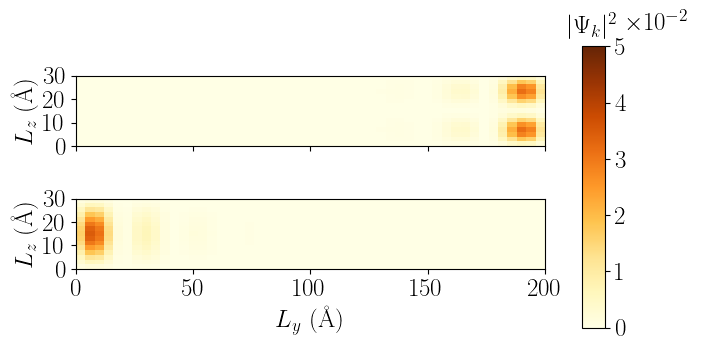

In [37]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

kx_selected_index = N_k//2+1

num_minima = 30

energies_for_kx = energy_kx[kx_selected_index, :]

sorted_indices = np.argsort(np.abs(energies_for_kx))[:num_minima]

min_values = [(band_idx, energies_for_kx[band_idx]) for band_idx in sorted_indices]

nbands = sorted_indices  


state0 = 2
state1 = 5
ki = [N_k // 2 + 1]
print("kx selected:", kx_values[ki[0]])

a = H_params["a"]
c = H_params["c"]

Ly = int(H_params["L_y"] / a)
Lz = int(H_params["L_z"] / c)

print("Lx, Lz (number of sites):", [Ly, Lz])


Dense   = kwant.operator.Density(syst, np.diag([1, 1, 1, 1]))
DenseSZ = kwant.operator.Density(syst, np.diag([1, -1, -1, 1]))
DensePQ = kwant.operator.Density(syst, np.diag([1, -1, 1, -1]))

u0 = eigenvectors_kx[ki[0], :, nbands[state0]]
u1 = eigenvectors_kx[ki[0], :, nbands[state1]]

en_state = energy_kx[ki[0], nbands[state0]]


avg    = np.sum(Dense(u0))
avg_SZ = np.sum(DenseSZ(u0))
avg_PQ = np.sum(DensePQ(u0))


legend_elements = [
    plt.Text(0, 0, fr'$<D> = {avg:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|S_z|\psi_k>| = {avg_SZ:.5f}$'),
    plt.Text(0, 0, fr'$|<\psi_k|P|\psi_k>| = {avg_PQ:.5f}$'),
    plt.Text(0, 0, fr'$E_k = {en_state:.6f}$'),
]

density_array0 = Dense(u0)
density_array1 = Dense(u1)

vmax = 5e-2
vmin = 0

norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap='YlOrBr')

plt.rcParams.update({         
    "font.size": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18
})

fig, axs = plt.subplots(2, 1, figsize=(10*0.75, 6*0.75), sharex=True)

extent = [0, Ly * a, 0, Lz * c]  

axs[0].imshow(density_array0.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='YlOrBr')
axs[1].imshow(density_array1.reshape([Ly, Lz]).T, origin='lower',
              extent=extent, vmin=vmin, vmax=vmax, cmap='YlOrBr')

for ax in axs:
    ax.set_ylabel(r'$L_z$ ($\mathrm{\AA}$)')
    ax.set_yticks([0, 10, 20, 30])               
    ax.set_yticklabels([0, 10, 20, 30])          
    ax.tick_params(labelsize=18)

axs[1].set_xlabel(r'$L_y$ ($\mathrm{\AA}$)')

fig.subplots_adjust(right=0.75, hspace=-0.45)

cbar_ax = fig.add_axes([0.8, 0.15, 0.03, 0.625])
cbar    = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title(r"$|\Psi_k|^2$", fontsize=18,pad=10)


cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()

cbar.ax.yaxis.get_offset_text().set_visible(False)

cbar.ax.text(
    2.,          
    1.05,           
    r"$\times 10^{-2}$",
    transform=cbar.ax.transAxes,
    ha='left', va='bottom',
    fontsize=18
)

#plt.tight_layout()
plt.savefig('Figs/StatesSlabMagnetic.svg')
plt.show()

In [38]:
import sys, numpy, scipy, matplotlib, kwant, tqdm
print("Python:", sys.version.split()[0])
print("NumPy:  ", numpy.__version__)
print("SciPy:  ", scipy.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Kwant:  ", kwant.__version__)
import tqdm as _tqdm
print("tqdm:   ", _tqdm.__version__)

Python: 3.12.2
NumPy:   1.26.4
SciPy:   1.13.1
Matplotlib: 3.10.0
Kwant:   1.5.0
tqdm:    4.66.5
